![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [18]:
import warnings
warnings.filterwarnings('ignore')
decision = 2 #1 Correr normalmente, 2 cargar info

In [19]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import pickle
import joblib

#from keras.preprocessing import sequence
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import nltk
import math

#nltk.download('omw')


from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.activations import relu, swish, sigmoid
from livelossplot import PlotLossesKeras
#from sentence_transformers import SentenceTransformer

In [20]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [21]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [22]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [23]:
#Pasar palabras a minusculas
def minusculizar(df):
    df2 = df.copy()
    df2['title'] = df2['title'].apply(lambda x : x.lower())
    df2['plot'] = df2['plot'].apply(lambda x : x.lower())
    return df2

dataTraining_min  = minusculizar(dataTraining)
dataTraining_min

,year,title,plot,genres,rating
3107,2003,most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,how to be a serial killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,a woman's face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,executive suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,narrow margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6
...,...,...,...,...,...
8417,2010,our family wedding,""" our marriage , their wedding . "" it ' s l...","['Comedy', 'Romance']",4.9
1592,1984,conan the destroyer,"the wandering barbarian , conan , alongside ...","['Action', 'Adventure', 'Fantasy']",5.8
1723,1955,kismet,"like a tale spun by scheherazade , kismet fol...","['Adventure', 'Musical', 'Fantasy', 'Comedy', ...",6.4
7605,1982,the secret of nimh,"mrs . brisby , a widowed mouse , lives in a...","['Animation', 'Adventure', 'Drama', 'Family', ...",7.6


Plots

In [24]:
Listadeplots = dataTraining_min['plot'].tolist()
lista_palabras=[]
for i in Listadeplots:
    lista_palabras.extend(i.split())
palabras_unicas_plot = list(set(lista_palabras))

stopwords_english = nltk.corpus.stopwords.words('english')

lista_palabras_completa_filtrada = [palabra for palabra in lista_palabras if palabra.lower() not in stopwords_english]
lista_filtrada_plot = set(lista_palabras_completa_filtrada)

len(palabras_unicas_plot),len(lista_filtrada_plot)

(38734, 38584)

Creacion del diccionario de lematización

In [25]:
# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Mapear las etiquetas POS de NLTK a las etiquetas POS de WordNet
tag_map = {
    'N': nltk.corpus.wordnet.NOUN,
    'V': nltk.corpus.wordnet.VERB,
    'R': nltk.corpus.wordnet.ADV,
    'J': nltk.corpus.wordnet.ADJ
}

# Lematizar la lista de palabras
lista_lematizada = []
for palabra in lista_filtrada_plot:
    # Obtener la etiqueta POS de cada palabra
    pos_tag = nltk.pos_tag([palabra])[0][1][0].upper()
    # Mapear la etiqueta POS a las etiquetas POS de WordNet
    pos_tag = tag_map.get(pos_tag, nltk.corpus.wordnet.NOUN)
    
    # Lematizar la palabra
    lema = lemmatizer.lemmatize(palabra, pos=pos_tag)
    lista_lematizada.append(lema)

# Imprimir la lista de palabras lematizada
print(lista_lematizada)

diccionario_original_a_lemas = {clave: valor for clave, valor in zip(lista_filtrada_plot, lista_lematizada)}


lista_unicos_lematizada = list(set(lista_lematizada))
len(lista_unicos_lematizada)

['fulfil', 'hemsley', 'halt', 'enrol', 'crawl', 'learn', 'banjo', 'fincham', 'label', 'futurist', 'knockabout', 'picklers', 'savitch', 'chocolate', 'aspect', 'tarker', 'sandstorm', 'tailor', 'influence', 'allen', 'militant', 'arnie', 'differentiate', 'beddoe', 'decadent', 'taffy', 'aylesbury', 'caspar', 'individual', 'kimura', 'lilian', 'speranza', 'available', 'walton', 'spade', 'dray', 'quartete', 'orphan', 'chewbacca', 'invest', 'hilt', 'spare', 'cardin', 'iambic', 'tobey', 'vinnie', 'overwhelmed', 'bmws', 'manufacturer', 'nel', 'ahkmenrah', 'firebomb', 'pennant', 'pocketknife', 'outing', 'meester', 'aficionado', 'bloodline', 'dimwit', 'lieutenant', 'precedence', 'onlooker', 'jones', 'cryogenic', 'hourly', 'deem', 'flunk', 'narrative', 'stage', 'faster', 'ayer', 'pronti', 'flappy', 'racketeering', 'feuerstein', 'coax', 'nuzzle', 'kazuo', 'doniger', 'university', 'talkin', 'delvin', 'uncanny', 'commander', 'beatnik', 'marcellus', 'hillbilly', 'spot', 'widow', 'milanese', 'marisol', '

31371

Palabras lematizadas más comunes

In [26]:
df_Listado_completo_filtrado_no_stopwords = pd.DataFrame(lista_palabras_completa_filtrada,columns=['words'])
df_Listado_completo_filtrado_no_stopwords['Lematized'] = df_Listado_completo_filtrado_no_stopwords['words'].apply(lambda x : diccionario_original_a_lemas[x])
df_Listado_completo_filtrado_no_stopwords['Count'] = 1
Repeticiones_por_lematized = df_Listado_completo_filtrado_no_stopwords[['Lematized','Count']].groupby('Lematized').sum().reset_index().sort_values('Count',ascending=False)
filtro = Repeticiones_por_lematized['Lematized'].apply(lambda x: len(x) > 1)
resultados_filtrados = Repeticiones_por_lematized[filtro].reset_index(drop=True)
Total_palabras = resultados_filtrados['Count'].sum()
resultados_filtrados['Part'] = resultados_filtrados['Count'].apply(lambda x: x/Total_palabras)
resultados_filtrados['Acumulado'] = resultados_filtrados['Part'].cumsum()
Porcentaje = 1.01
pareto = resultados_filtrados[resultados_filtrados['Acumulado']<=Porcentaje].shape
print('El '+str(Porcentaje*100) + '% de las palabras se encuentra en las primeras ' + str(pareto[0]))

Palabras_Para_Clasificar_Lematizadas = resultados_filtrados[resultados_filtrados['Acumulado']<=Porcentaje]['Lematized'].tolist()

vocabulario_lematizado = {palabra: indice for indice, palabra in enumerate(Palabras_Para_Clasificar_Lematizadas)}

resultados_filtrados.head(10)

El 101.0% de las palabras se encuentra en las primeras 31330


,Lematized,Count,Part,Acumulado
0,life,3640,0.006784,0.006784
1,one,3068,0.005718,0.012502
2,get,3068,0.005718,0.018219
3,find,2875,0.005358,0.023577
4,go,2405,0.004482,0.028059
5,new,2271,0.004232,0.032292
6,take,2240,0.004175,0.036466
7,friend,2190,0.004081,0.040548
8,year,2085,0.003886,0.044434
9,make,2057,0.003834,0.048267


Variable de interes

In [27]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

Lematizar texto original y eliminar stopwords

In [28]:
def lematizar_texto(texto, diccionario):
    palabras = texto.split()  # Dividir el texto en palabras
    palabras_lematizadas = [diccionario.get(palabra, palabra) for palabra in palabras]  # Obtener las palabras lematizadas del diccionario
    palabras_filtradas = [palabra for palabra in palabras_lematizadas if palabra.lower() not in stopwords_english]  # Filtrar las stopwords
    texto_lematizado = ' '.join(palabras_filtradas)  # Unir las palabras lematizadas en un nuevo texto
    return texto_lematizado

dataTraining_min['plot_lematized'] = dataTraining_min['plot'].apply(lambda x: lematizar_texto(x,diccionario_original_a_lemas))
dataTraining_min.head()


,year,title,plot,genres,rating,plot_lematized
3107,2003,most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,story single father take eight year - old son ...
900,2008,how to be a serial killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,serial killer decides teach secret satisfy car...
6724,1941,a woman's face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"sweden , female blackmailer disfigure facial s..."
4704,1954,executive suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,"friday afternoon new york , president tredway ..."
2582,1990,narrow margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"los angeles , editor publishing house carol hu..."


Conteo de palabras por cada genero

In [30]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

if decision == 1:
    dataTraining_plot = dataTraining_min['plot_lematized'].reset_index(drop=True)

    df_y_genres = pd.DataFrame(y_genres,columns=cols)
    df_a_evaluar = pd.concat((dataTraining_plot,df_y_genres),axis=1)

    participaciones = pd.DataFrame(index=vocabulario_lematizado, columns=df_a_evaluar.columns[1:])
    participaciones
    contador=1
    actual = 0.05
    for palabra in vocabulario_lematizado:
        # Calcular la participación de la palabra en cada género
        completado= contador/len(vocabulario_lematizado)
        if completado > actual:
            print('% Completado: ' + str(round(actual*100,0)))
            actual += 0.05

        for genero in df_a_evaluar.columns[1:]:
            total_words = df_a_evaluar[df_a_evaluar[genero] == 1]['plot_lematized'].apply(len).sum()
            # Calcular la frecuencia de aparición de la palabra en el género
            freq = df_a_evaluar[df_a_evaluar[genero] == 1]['plot_lematized'].str.count(palabra).sum()
            # Almacenar la participación en el DataFrame
            participaciones.at[palabra, genero] = freq
        contador +=1 

    participaciones.head()

    joblib.dump(participaciones,'Participaciones2.pkl', compress=3)
    joblib.dump(df_a_evaluar,'df_a_evaluar.pkl', compress=3)
else:
    participaciones = joblib.load('Participaciones 100% de las palabras.pkl')
    df_a_evaluar = joblib.load('df_a_evaluar.pkl')
    print('se cargaron particiones y df evaluar desde los datos guardados')

% Completado: 5.0
% Completado: 10.0
% Completado: 15.0
% Completado: 20.0
% Completado: 25.0
% Completado: 30.0
% Completado: 35.0
% Completado: 40.0
% Completado: 45.0
% Completado: 50.0
% Completado: 55.0
% Completado: 60.0
% Completado: 65.0
% Completado: 70.0
% Completado: 75.0
% Completado: 80.0
% Completado: 85.0
% Completado: 90.0
% Completado: 95.0


['Participaciones2.pkl']

Conteo ponderado

In [31]:
suma_filas = participaciones.sum(axis=1)
participaciones_por_fila = participaciones.div(suma_filas, axis=0)
participaciones_por_fila.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
life,0.039037,0.035613,0.009197,0.023481,0.152725,0.055865,0.016926,0.247627,0.027395,0.034439,...,0.010664,0.028079,0.000391,0.126113,0.024264,0.001272,0.012621,0.072987,0.013404,0.00724
one,0.066641,0.050104,0.008896,0.014846,0.131754,0.075483,0.010479,0.187698,0.025925,0.031001,...,0.012171,0.042517,0.000164,0.08891,0.032256,0.00262,0.011243,0.10512,0.017465,0.011898
get,0.063739,0.046315,0.010045,0.007912,0.17886,0.076007,0.005512,0.177882,0.034314,0.028536,...,0.013868,0.031025,0.0,0.109965,0.025336,0.002845,0.012179,0.09183,0.014046,0.009956
find,0.062366,0.057486,0.014639,0.009284,0.131516,0.067841,0.003809,0.163413,0.03761,0.040109,...,0.012378,0.051892,0.0,0.084742,0.041895,0.001904,0.007498,0.107593,0.012973,0.00976
go,0.07375,0.059133,0.011778,0.012563,0.14309,0.070669,0.009181,0.172203,0.035335,0.039865,...,0.011718,0.032737,0.000302,0.084803,0.034972,0.002718,0.012745,0.097065,0.012986,0.012443


Revisión de balanceo de clases

In [97]:
lista_repetidos=[]
for i in df_a_evaluar.columns[1:]:
    lista_repetidos.append(df_a_evaluar[i].sum())
Balance_DF = pd.DataFrame(zip(df_a_evaluar.columns[1:],lista_repetidos),columns=['genero','Cant']).sort_values(by='Cant',ascending=False)
Balance_DF

,genero,Cant
7,p_Drama,3965
4,p_Comedy,3046
21,p_Thriller,2024
17,p_Romance,1892
5,p_Crime,1447
0,p_Action,1303
1,p_Adventure,1024
12,p_Horror,954
15,p_Mystery,759
18,p_Sci-Fi,723


Calculo de tf_IDF

In [32]:
joblib.dump(participaciones,'Participaciones.pkl', compress=3)

tf_idf_values = participaciones * 0
# Número total de géneros
total_genres = len(df_a_evaluar.columns) - 1

# Calcular la frecuencia de aparición de cada palabra en cada género
for genre in df_a_evaluar.columns[1:]:
    total_words = df_a_evaluar[df_a_evaluar[genre] == 1]['plot_lematized'].apply(len).sum()
    for word in participaciones.index:
        freq = participaciones.loc[word, genre]
        tf = freq / total_words
        num_genres_with_word = participaciones.loc[word].gt(0).sum()  # Número de géneros en los que aparece la palabra
        idf = math.log(total_genres / num_genres_with_word)
        tf_idf = tf * idf        
        tf_idf_values.loc[word, genre] = tf_idf

Valores_Tf_Idf_Mas_Altos = tf_idf_values.sum(axis=1).sort_values(ascending=False)
Valores_Tf_Idf_Mas_Altos.head(10)

showrunners    0.003565
swartz         0.002311
rd             0.001688
wi             0.001419
ant            0.001321
pi             0.001206
google         0.001050
ack            0.001044
pooh           0.000944
get            0.000942
dtype: float64

Analisis por métrica de TF_IDF por palabras

In [33]:
TF_IDF_Mas_Alto_Por_Genero = {}
Listado_palabras_unicas_por_Tf_Idf = []
Nuevo_vocabulario_por_Tf_Idf  = {}
max_palabras = 600
for i in tf_idf_values.columns:
    Words_selected = tf_idf_values[i].sort_values(ascending=False).reset_index()['index'].tolist()[:max_palabras]
    TF_IDF_Mas_Alto_Por_Genero[i]= Words_selected
    Listado_palabras_unicas_por_Tf_Idf.extend(Words_selected)
Listado_palabras_unicas_por_Tf_Idf = list(set(Listado_palabras_unicas_por_Tf_Idf))
Nuevo_vocabulario_por_Tf_Idf = {palabra: indice for indice, palabra in enumerate(Listado_palabras_unicas_por_Tf_Idf)}


print(len(TF_IDF_Mas_Alto_Por_Genero),len(Listado_palabras_unicas_por_Tf_Idf),len(Nuevo_vocabulario_por_Tf_Idf))
#Nuevo_vocabulario_por_Tf_Idf

24 7566 7566


Vectorización

In [34]:
Opciones_para_Vocabularios = {1:vocabulario_lematizado,2:Nuevo_vocabulario_por_Tf_Idf}
vectorizer = CountVectorizer(vocabulary=Opciones_para_Vocabularios[2]) #Opcion 1
xplot_vectorizer = vectorizer.transform(dataTraining_min['plot_lematized'])
features = vectorizer.get_feature_names_out()
prueba = dataTraining_min['plot_lematized'].tolist()[2].split()
print(xplot_vectorizer.shape)
xplot_vectorizer

(7895, 7566)


<7895x7566 sparse matrix of type '<class 'numpy.int64'>'
	with 148669 stored elements in Compressed Sparse Row format>

In [35]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(xplot_vectorizer, y_genres, test_size=0.33, random_state=42)

In [95]:
# Definición y entrenamiento
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [96]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)


# Cálculo del AUC de cada clase
auc_scores = roc_auc_score(y_test_genres, y_pred_genres, average=None)

AUC_TOTAL=roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print('AUC_TOTAL: ' +str(AUC_TOTAL))
# Impresión del AUC de cada clase

Para_df={}
for class_idx, auc_score in enumerate(auc_scores):
    Para_df[cols[class_idx]]=auc_score
DF_AUC_Generos = pd.DataFrame(Para_df.values(),columns=['AUC'],index=Para_df.keys())
DF_AUC_Generos=DF_AUC_Generos.sort_values(by='AUC')

Estimador_Vs_AUCS = [clf,AUC_TOTAL,DF_AUC_Generos]

joblib.dump(Estimador_Vs_AUCS,'Lista_2_params_por_defecto_25-05-23 AUC' + str(AUC_TOTAL)+'.pkl', compress=3)

DF_AUC_Generos

AUC_TOTAL: 0.8248505282185744


,AUC
p_Drama,0.706446
p_Biography,0.735655
p_Comedy,0.760563
p_History,0.766654
p_Film-Noir,0.777821
p_Musical,0.780469
p_Romance,0.785054
p_Fantasy,0.788135
p_Thriller,0.790043
p_Short,0.794591


prueba 1 redes neuronales

In [66]:
from keras.losses import categorical_crossentropy


In [73]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(500, input_shape=(X_train.shape[1],),activation=sigmoid))
model.add(Dropout(0.10769379659079174))
model.add(Dense(500,activation=sigmoid))
model.add(Dropout(0.2))
model.add(Dense(24, activation=sigmoid))

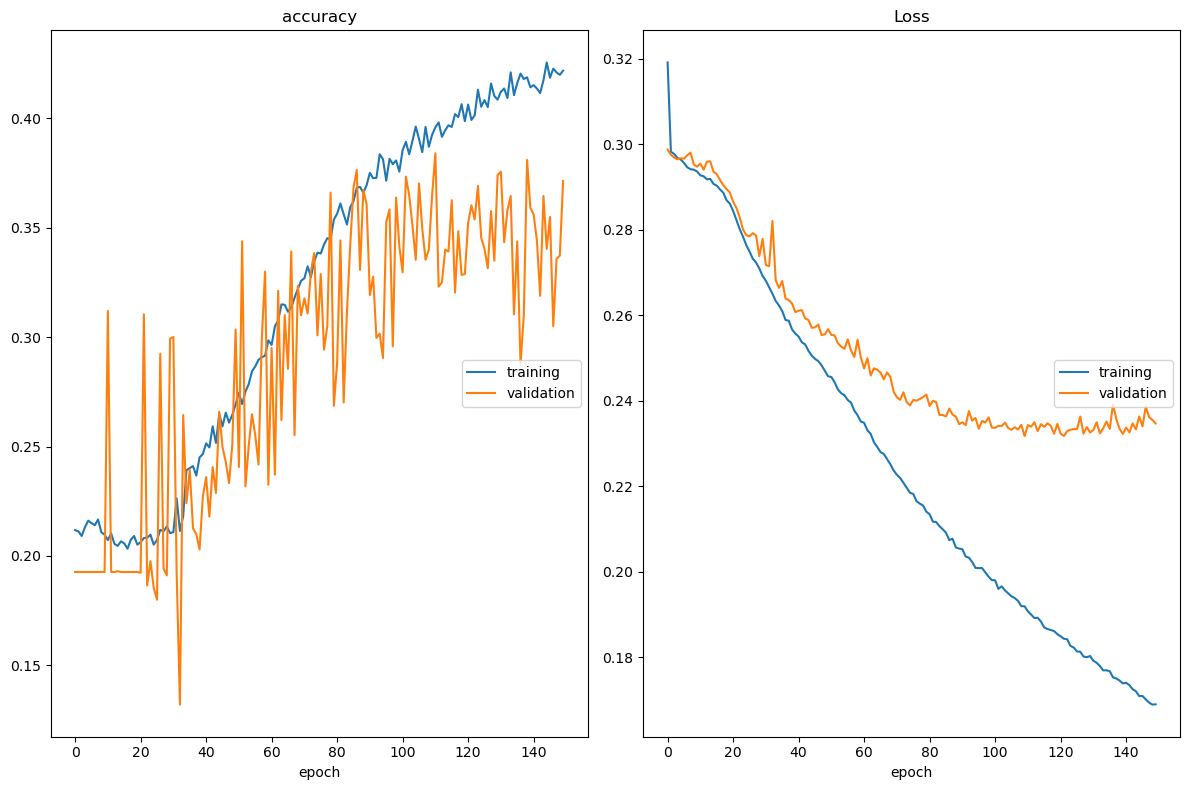

accuracy
	training         	 (min:    0.203, max:    0.426, cur:    0.422)
	validation       	 (min:    0.132, max:    0.384, cur:    0.371)
Loss
	training         	 (min:    0.169, max:    0.319, cur:    0.169)
	validation       	 (min:    0.232, max:    0.299, cur:    0.235)
42/42 [==============================] - 1s 32ms/step - loss: 0.1689 - accuracy: 0.4218 - val_loss: 0.2347 - val_accuracy: 0.3715


In [74]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train_genres, validation_data=(X_test, y_test_genres),batch_size=128, epochs=150, verbose=1,callbacks=[PlotLossesKeras()])

In [75]:
# Cálculo del AUC de cada clase
y_pred_genres=model.predict(X_test)
auc_scores = roc_auc_score(y_test_genres, y_pred_genres, average=None)

AUC_TOTAL=roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print('AUC_TOTAL: ' +str(AUC_TOTAL))
# Impresión del AUC de cada clase

Para_df={}
for class_idx, auc_score in enumerate(auc_scores):
    Para_df[cols[class_idx]]=auc_score
DF_AUC_Generos = pd.DataFrame(Para_df.values(),columns=['AUC'],index=Para_df.keys())
DF_AUC_Generos=DF_AUC_Generos.sort_values(by='AUC')


DF_AUC_Generos

82/82 [==============================] - 0s 4ms/step
AUC_TOTAL: 0.8430740146634687


,AUC
p_Drama,0.732779
p_Comedy,0.763077
p_Film-Noir,0.790692
p_Short,0.796830
p_Musical,0.797948
p_Romance,0.801974
p_Biography,0.803731
p_Thriller,0.810279
p_Fantasy,0.824717
p_Mystery,0.835242


In [43]:
fdsfdssfd +1

NameError: name 'fdsfdssfd' is not defined

In [ ]:
output_var = y_train_genres.shape[1]
print(output_var, ' output variables')

In [ ]:
dims = X_train.shape[1]
print(dims, 'input variables')

In [ ]:
# Importación librerías
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

In [ ]:
# Definición de función que crea una red neuronal a partir de diferentes parámetros (nn_model_params)
# En esta función se consideran 7 parámetos a calibrar, sin embargo se pueden agregar o quitar tantos como lo consideren pertinente
def nn_model_params(optimizer ,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    loss):
    
    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()
    
    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation=activation))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = optimizer, loss=loss)
    
    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, y_train_genres,
              validation_data = (X_test, y_test_genres),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

In [ ]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'optimizer': ['adam','sgd'],
    'activation': ['sigmoid'],
    'batch_size': [64,128],
    'neurons':[64,256],
    'epochs':[40,100],
    'patience':[2,5],
    'loss':['binary_crossentropy']
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
nn_model = KerasClassifier(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
rs = RandomizedSearchCV(nn_model, param_distributions=nn_params, n_iter=5, cv=3)
rs.fit(X_train, y_train_genres)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

prueba 2 redes neuronales LSTM

In [ ]:
# Definición red neuronal con la función Sequential()
model = Sequential()

# Definición de la capa embedding
model.add(Embedding(len(Opciones_para_Vocabularios[2]) + 1, 128, input_length=X_train.shape[1]))
# Definición de la capa recurrente LSTM
model.add(LSTM(32))
# Definición de dropout para evitar overfitting
model.add(Dropout(0.5))
# Definición capa densa con función sigmoide para predicción binaria final
model.add(Dense(24, activation='sigmoid'))

# Definición de función de perdida.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Impresión de la arquitectura de la red neuronal
model.summary()

transformación de conjunto de test

In [76]:
dataTesting_min  = minusculizar(dataTesting)
dataTesting_min['plot_lematized'] = dataTesting_min['plot'].apply(lambda x: lematizar_texto(x,diccionario_original_a_lemas))
dataTesting_min.head()
xplot_vectorizer_test = vectorizer.transform(dataTesting_min['plot_lematized'])
xplot_vectorizer_test.shape

(3383, 7566)

In [77]:
# transformación variables predictoras X del conjunto de test
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = model.predict(xplot_vectorizer_test)

106/106 [==============================] - 0s 3ms/step


In [78]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_XGBoost_Tfidf.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.047327,0.060741,2.459641e-03,0.033382,0.369582,0.068212,0.003405,0.618242,5.982229e-03,0.051119,...,0.015898,0.115930,0.001096,0.397450,0.024354,0.007716,0.002472,0.354863,0.024308,0.029009
4,0.070160,0.031400,7.685760e-03,0.047870,0.488983,0.187697,0.080180,0.416630,2.216229e-02,0.018997,...,0.007715,0.036613,0.001588,0.040856,0.040933,0.019697,0.025495,0.206544,0.009465,0.022161
5,0.000688,0.000009,2.712133e-09,0.143129,0.002225,0.970560,0.000864,0.995405,3.082791e-08,0.000006,...,0.000008,0.370522,0.000059,0.046551,0.000044,0.000013,0.000061,0.889170,0.004515,0.000959
6,0.017953,0.008858,3.759825e-05,0.035713,0.070933,0.055953,0.001197,0.896876,2.040428e-04,0.001801,...,0.000754,0.039851,0.000286,0.115260,0.003144,0.000671,0.002374,0.406069,0.056621,0.013976
7,0.008610,0.013598,1.068177e-03,0.001889,0.186912,0.005656,0.001585,0.151470,3.210445e-03,0.095526,...,0.001163,0.213300,0.000201,0.016184,0.412912,0.003075,0.000044,0.514890,0.000139,0.001674
